### Notebook with Python code to create figures for paper: South American Monsoon variability over the last millennium in paleoclimate records and isotope-enabled climate models.

V - MCA / LIA anomalies relative to the LM: cesm full forcing and overlaid proxy records

___

Rebecca Orrison 

In [8]:
#numerical computation
import numpy as np
import pandas as pd
import xarray as xr
import os.path
import sys

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
import proplot as pplt
import scipy.stats

plt.rcParams.update({'font.sans-serif':'Arial'})


In [2]:
# ------
# DEFINE FUNCTIONS FOR SUBSETTING REGIONS, plotting, etc
# ------  
            #should i write up this all as a function? so the input spits right out the latitudinal array of interest?
            #as richard said.
                # Wavelet analysis was strictly > or <.  EOFS are inclusive
def lat_ind_fn(latl,latu):
    return np.where((lat >= latl) & (lat <= latu))
    
def lon_ind_fn(lonl,lonu):
    return np.where((lon >= lonl) & (lon <= lonu))

def geo_idx(target,array):
    return np.abs(array - target).argmin()

def geo_loc(target,array):
    return array[np.abs(array - target).argmin()]

def bounds(scalar_fields):
    """
    Get the bounds of a set of scalar_fields
    :param scalar_fields : the scalar field set
    :return: a set of normalized vector field components
    """
    max_bound = -np.inf
    min_bound = np.inf

    for scalar_field in scalar_fields:
        max_lim = np.max(scalar_field)
        min_lim = np.min(scalar_field)
        if max_lim > max_bound:
            max_bound = max_lim
        if min_lim < min_bound:
            min_bound = min_lim

    return np.around(min_bound,2), np.around(max_bound, 2)

# Load data

In [3]:
# Load CESM_LME-ff data for all diagnostics:
path = "/network/rit/home/ro553136/orrison/data/CESM/iLME/"
scenario = 'fullforcing/'
dirs = ['omega/','prect/','prect/']
vari = ['OMEGA','d18O_pwt','PRECT']
fs = ['b.ie12.B1850C5CN.f19_g16.LME.ensavg.cam.h0.OMEGA.085001-184912_djf.nc',
      'b.ie12.B1850C5CN.f19_g16.LME.ensavg.cam.h0.d18O_pwt.085001-184912_djf.nc',
      'b.ie12.B1850C5CN.f19_g16.LME.ensavg.cam.h0.PRECT.085001-184912_djf.nc']

diagdict = {}
for i,var in enumerate(vari):
    diagdict[var] = xr.open_dataset(path + scenario + dirs[i] + fs[i], chunks={'time':12})
    diagdict[var] = diagdict[var].assign_coords(time = ("time",np.arange(850,1849)))
    if var == 'OMEGA':
        diagdict[var] = diagdict[var].sel(lev=500, method='nearest')
        diagdict[var] = diagdict[var].sel(lat=slice(-30,5))

lat_cesm = diagdict[var].lat
lon_cesm = diagdict[var].lon

# Load abs values of mceof proxy data
recs = ['PAL', 'HUA1', 'PAR', 'DV2', 'SBE+SMT', 'TMO', 'CRT1', 'JAR', 'ALH', 'BOTO', 'PIM4', 'MV', 'QUELC3', 'PUM12']
lat_pts = [-5.92, -11.27, -4.00, -12.36, -13.81, -16.00, -24.58, -21.08, -15.20, -18.12, -11.4, -11.62, -13.93, -10.07]
lon_pts = [282.65, 284.21, 304.73, 318.43, 313.65, 313.00, 311.42, 304.42, 303.20, 294.23, 299.62, 312.51, 289.17, 283.94]
    # interpolate huagapo to a lower position
lat_pts_nn_hua = (geo_loc(lat_pts[1],lat_cesm) - (lat_cesm[1]-lat_cesm[0])).values
lat_pts[1] = lat_pts_nn_hua
rec_dict = {'modpts': recs,'lat': lat_pts, 'lon': lon_pts}

f = open("/network/rit/lab/vuillelab_rit/orrison/data/proxy/mceof_recs/mceof_recs_all_Sept21.csv")

mcrecs = pd.read_csv(f, index_col=0)
abs_prox_all = []

i = 0
while (i < len(mcrecs)):
    abs_prox = mcrecs.iloc[0+i:1000+i]
    abs_prox_all.append(abs_prox)
    i += 1001

/network/rit/lab/vuillelab_rit/orrison/bin/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Subset proxies and model for MCA/LIA

# - MCA: (724) 850–1160 CE
# - LIA: 1489–1850 (1878) CE 
mcaa_mcavg_prx = {}
liaa_mcavg_prx = {}

for r in recs:
    mcaa_mcavg_prx[r] = np.mean([np.mean(abs_prox_all[i][r].loc[1159:850].astype(float)) - np.mean(abs_prox_all[i][r].astype(float)) for i in range(len(abs_prox_all))])
    liaa_mcavg_prx[r] = np.mean([np.mean(abs_prox_all[i][r].loc[1849:1489].astype(float)) - np.mean(abs_prox_all[i][r].astype(float)) for i in range(len(abs_prox_all))])
    
mcaa_mcavg_prxvals = [mcaa_mcavg_prx[r] for r in recs]
liaa_mcavg_prxvals = [liaa_mcavg_prx[r] for r in recs]

for i,var in enumerate(vari):
    diagdict[var]['lm'] = diagdict[var][var].mean(dim='time')
    diagdict[var]['mcaa'] = diagdict[var][var].sel(time=diagdict[var][var].time[0:310]).mean(dim='time') - diagdict[var]['lm']
    diagdict[var]['liaa'] = diagdict[var][var].sel(time=diagdict[var][var].time[550::]).mean(dim='time') - diagdict[var]['lm']

In [5]:
# sig testing
for i,var in enumerate(vari):
#     print(i)
    diagdict[var]['mcaa_tstat'],diagdict[var]['mcaa_pval'] = (xr.DataArray(np.zeros([len(lat_cesm), len(lon_cesm)]),coords={"lat":lat_cesm,"lon":lon_cesm},dims=["lat","lon"])), (xr.DataArray(np.zeros([len(lat_cesm), len(lon_cesm)]),coords={"lat":lat_cesm,"lon":lon_cesm},dims=["lat","lon"])) 
    diagdict[var]['liaa_tstat'],diagdict[var]['liaa_pval'] = (xr.DataArray(np.zeros([len(lat_cesm), len(lon_cesm)]),coords={"lat":lat_cesm,"lon":lon_cesm},dims=["lat","lon"])), (xr.DataArray(np.zeros([len(lat_cesm), len(lon_cesm)]),coords={"lat":lat_cesm,"lon":lon_cesm},dims=["lat","lon"])) 
    diagdict[var]['mcaa_mask'],diagdict[var]['liaa_mask'] = (xr.DataArray(np.NaN*np.empty([len(lat_cesm), len(lon_cesm)]),coords={"lat":lat_cesm,"lon":lon_cesm},dims=["lat","lon"])), (xr.DataArray(np.NaN*np.empty([len(lat_cesm), len(lon_cesm)]),coords={"lat":lat_cesm,"lon":lon_cesm},dims=["lat","lon"])) 
    for x in range(len(lat_cesm)):
        for y in range(len(lon_cesm)):
            diagdict[var]['mcaa_tstat'][x,y],diagdict[var]['mcaa_pval'][x,y] = scipy.stats.ttest_ind(diagdict[var][var][50:310,x,y],diagdict[var][var][:,x,y],equal_var=False)
            diagdict[var]['liaa_tstat'][x,y],diagdict[var]['liaa_pval'][x,y] = scipy.stats.ttest_ind(diagdict[var][var][550::,x,y],diagdict[var][var][:,x,y],equal_var=False)

#     diagdict[var]['mcaa_mask'] = diagdict[var]['mcaa_mask'].where(diagdict[var]['mcaa_pval'] > 0.05, diagdict[var]['mcaa_tstat'])
#     diagdict[var]['liaa_mask'] = diagdict[var]['liaa_mask'].where(diagdict[var]['liaa_pval'] > 0.05, diagdict[var]['liaa_tstat'])
    diagdict[var]['mcaa_mask_90'] = diagdict[var]['mcaa_mask'].where(diagdict[var]['mcaa_pval'] > 0.1, diagdict[var]['mcaa_tstat'])
    diagdict[var]['liaa_mask_90'] = diagdict[var]['liaa_mask'].where(diagdict[var]['liaa_pval'] > 0.1, diagdict[var]['liaa_tstat'])

0
1
2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

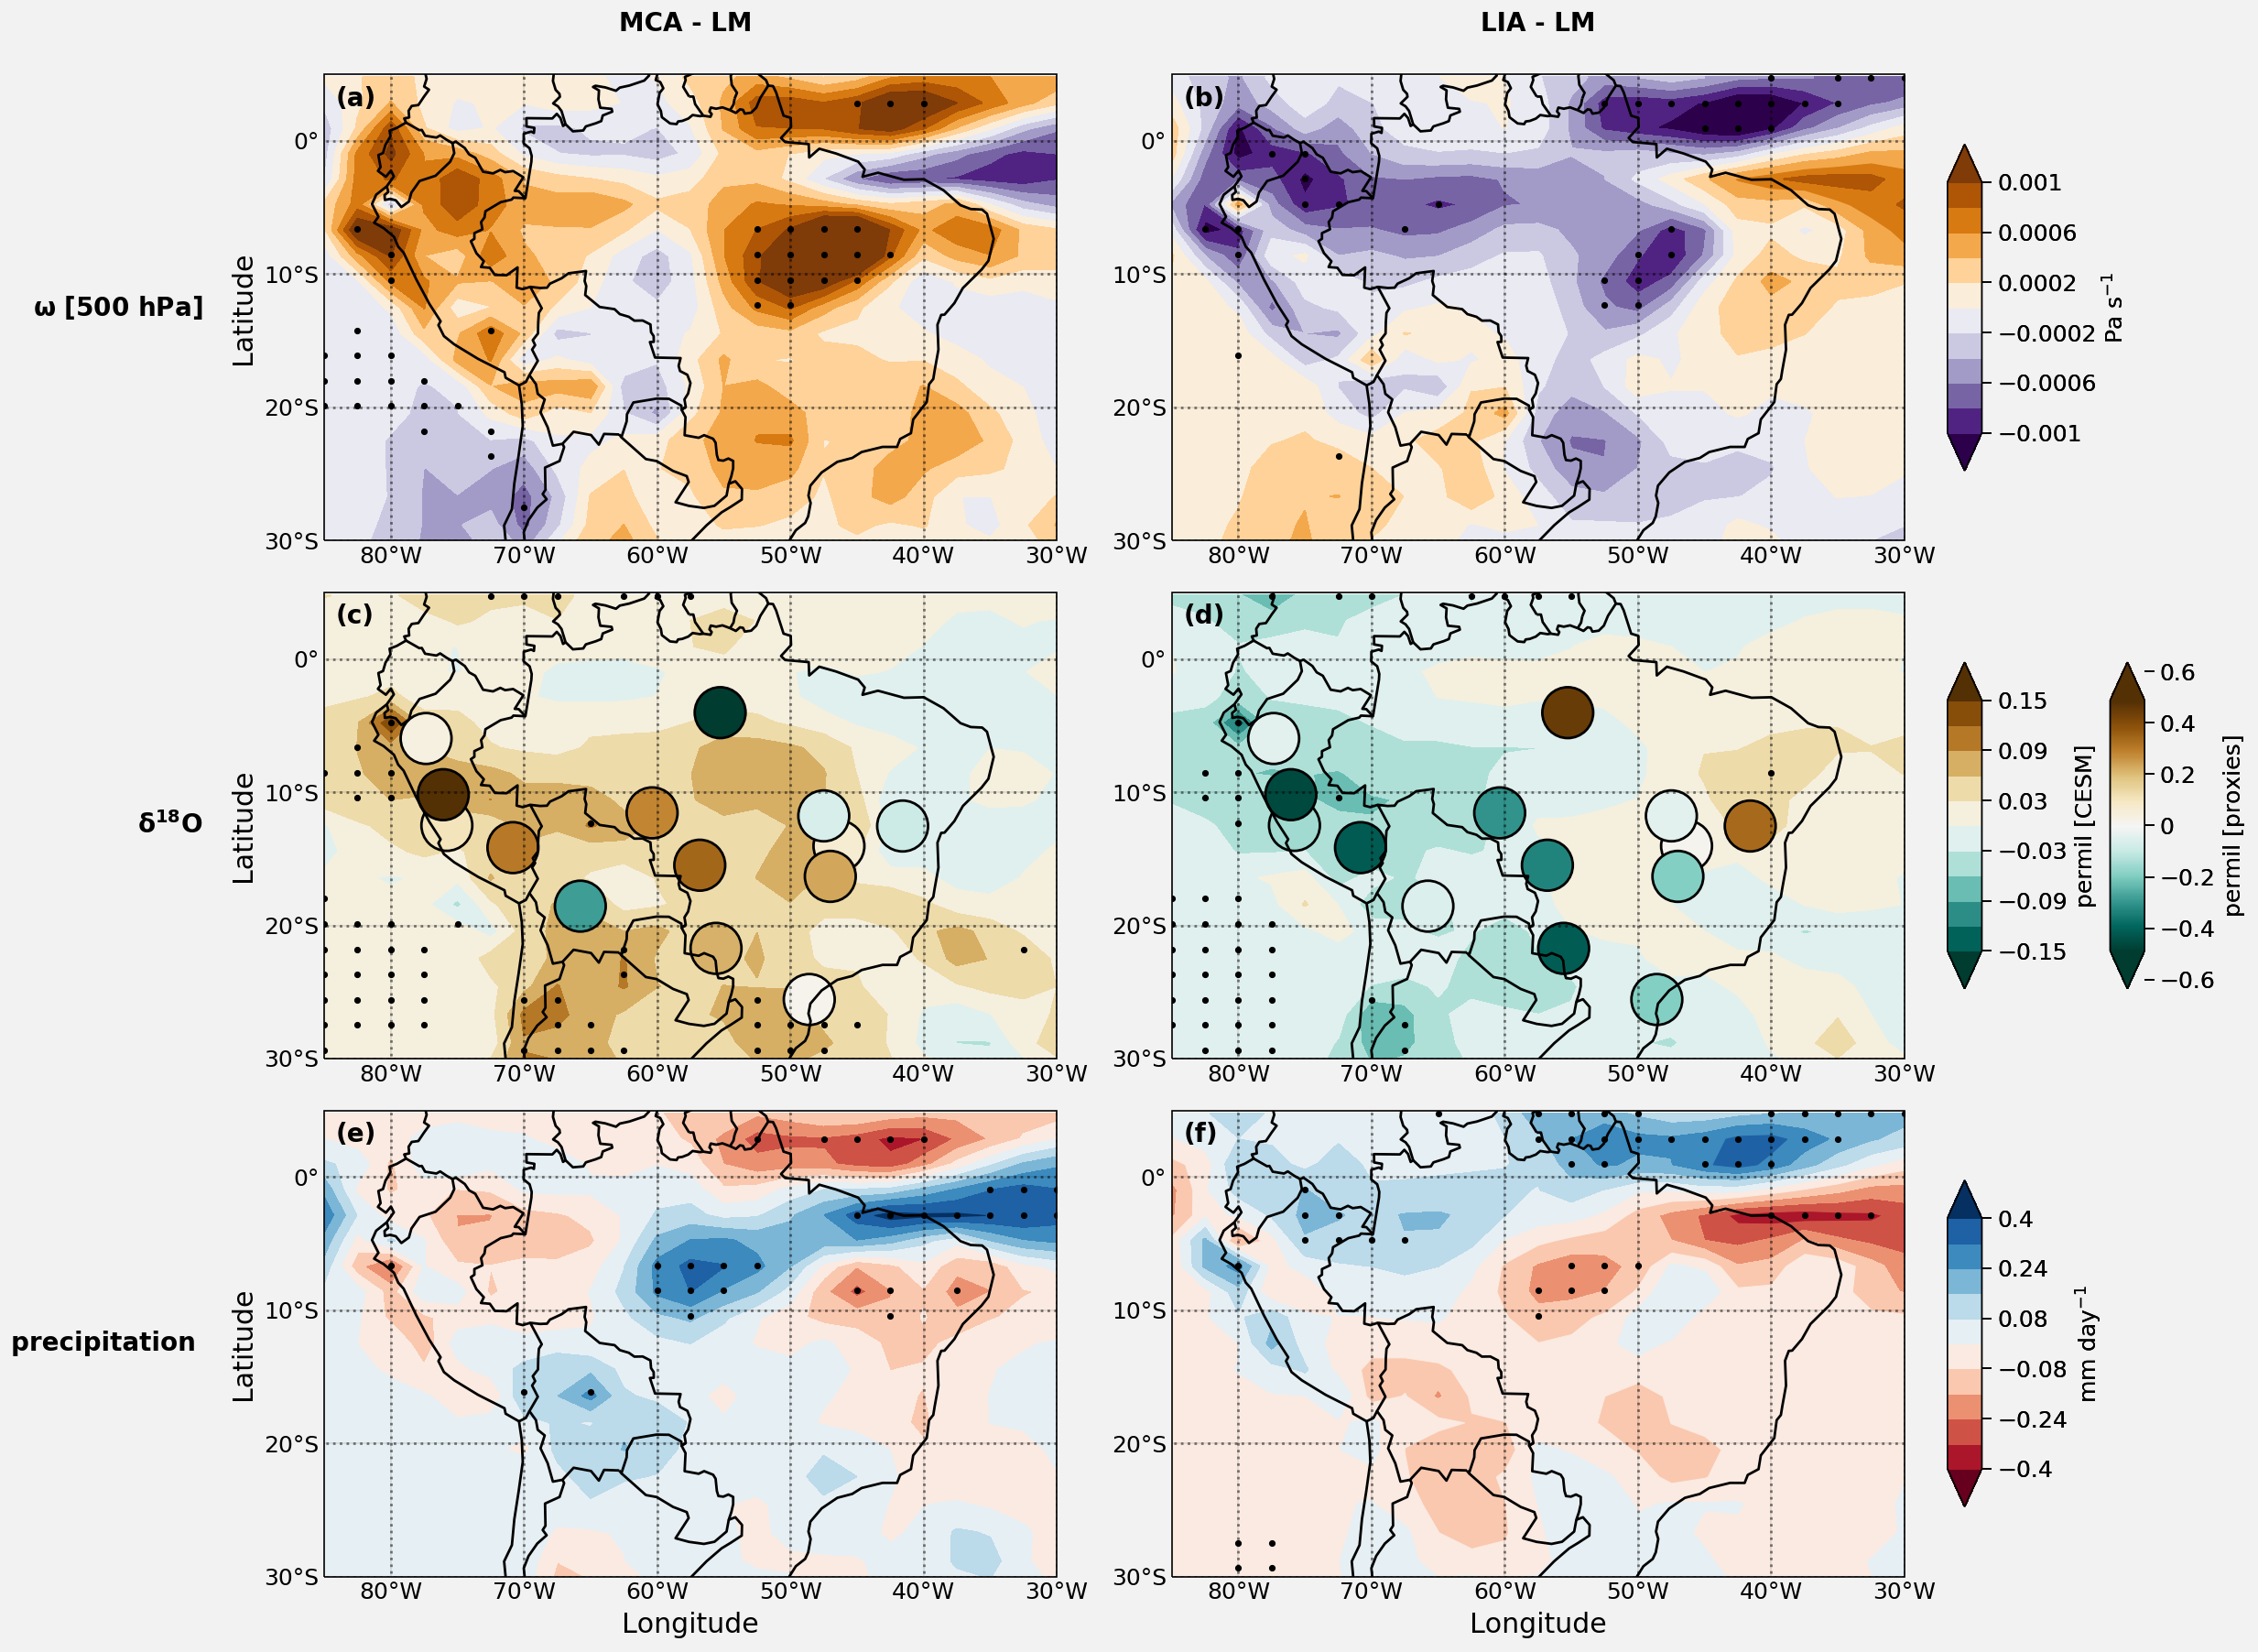

In [9]:
cmap = ['PuOr_r', 'BrBG_r', 'RdBu']
labs = [r'Pa $s^{-1}$', 'permil [CESM]', r'mm $day^{-1}$']
plt.rcParams.update({'font.sans-serif':'Arial'})

    # ------
    # Set up plotting framework: 
    # ------     
# make sure the sizes are right... 1920px wide and 1080px high
# MCA - LM and LIA - LM. specify in the caption the specific years, which is a quantitative detail of this qualitative description
fig, axs = pplt.subplots(ncols=2, nrows=3, axwidth=4, share=3, proj='cyl')
# fig.suptitle('MCA/LIA diagnostics with overlaid proxy data, CESM-LME-FF; DJF, p ≤ 0.1\n',size=24)
axs.format(land=False, labels=False, lonlines=10, latlines=10, 
           gridminor=True, abc=True, abcloc='ul', abcstyle='(a)',
           collabels=['MCA - LM \n','LIA - LM\n'],
           rowlabels=[r'$\omega$ [500 hPa]  ',r'$\delta^{18}O$  ','precipitation  '],
)
axs.coastlines()
axs.add_feature(cfeature.BORDERS)  
axs.set_extent([330,275,5,-30], crs=ccrs.PlateCarree()) 
axs.set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
axs.set_yticks([-30, -20,-10,0], crs=ccrs.PlateCarree())
lon_fmt = LongitudeFormatter(number_format='.0f')
lat_fmt = LatitudeFormatter(number_format='.0f')
[axs[i].xaxis.set_major_formatter(lon_fmt) for i in range(len(axs))]
[axs[i].yaxis.set_major_formatter(lat_fmt) for i in range(len(axs))]
for n,var in enumerate(vari):
    
    # ------
    # sig stippling 
    # ------ 
    stip_lat_mca = []
    stip_lon_mca = []
    stip_lat_lia = []
    stip_lon_lia = []
    for j in range(len(diagdict[var]['lm'].lat)):
        for k in range(len(diagdict[var]['lm'].lon)):
            if np.isnan(diagdict[var]['mcaa_mask_90'][j,k]) == False:
                stip_lat_mca.append(lat_cesm[j])
                stip_lon_mca.append(lon_cesm[k])
            if np.isnan(diagdict[var]['liaa_mask_90'][j,k]) == False:
                stip_lat_lia.append(lat_cesm[j])
                stip_lon_lia.append(lon_cesm[k])
            else: continue
    
    va_min_mod, va_max_mod = bounds([diagdict[var]['liaa'].values]+[diagdict[var]['mcaa'].values])
    
    axs[n,0].set_ylabel('Latitude', fontsize='large')

    if n == 0:
        va_min_mod, va_max_mod = (-0.001,0.001) #-max(abs(va_min_mod),abs(va_max_mod))*.3, max(abs(va_min_mod),abs(va_max_mod))*.3 #.75 is also good... 

    if n == 1:
        va_min_mod, va_max_mod = -max(abs(va_min_mod),abs(va_max_mod)), max(abs(va_min_mod),abs(va_max_mod)) 
        va_min_prox, va_max_prox = bounds([mcaa_mcavg_prxvals]+[liaa_mcavg_prxvals])
        va_min_prox, va_max_prox = -max(abs(va_min_prox),abs(va_max_prox))*.75, max(abs(va_min_prox),abs(va_max_prox))*.75  
    if n == 2:
        va_min_mod, va_max_mod = -max(abs(va_min_mod),abs(va_max_mod)), max(abs(va_min_mod),abs(va_max_mod)) 
        axs[n,:].set_xlabel('Longitude', fontsize='large')

    # ------
    # plotting 
    # ------  
    axs[n,0].contourf(lon_cesm, lat_cesm, diagdict[var]['mcaa'], transform=ccrs.LambertCylindrical(), cmap=cmap[n], vmin=va_min_mod, vmax=va_max_mod, extend='both')
    axs[n,0].scatter(stip_lon_mca,stip_lat_mca,s=10,c='k',marker='.')
    axs[n,0].set_title('')
    
    im = axs[n,1].contourf(diagdict[var]['liaa'], transform=ccrs.LambertCylindrical(), cmap=cmap[n], vmin=va_min_mod, vmax=va_max_mod, extend='both')
    axs[n,1].scatter(stip_lon_lia,stip_lat_lia,s=10,c='k',marker='.')
    axs[n,1].set_title('')
              
    axs[n,1].colorbar(im, loc='r', label=labs[n], tickloc='right',format='%.5f',length=0.7, extend='both')
    
    if n == 1:
        axs[n,0].scatter(lon_pts,lat_pts, c=mcaa_mcavg_prxvals, s=400, cmap=cmap[n], vmin=va_min_prox, vmax=va_max_prox, edgecolors='black', transform=ccrs.LambertCylindrical())
        ima = axs[n,1].scatter(lon_pts,lat_pts, c=liaa_mcavg_prxvals, s=400, cmap=cmap[n], vmin=va_min_prox, vmax=va_max_prox, edgecolors='black', transform=ccrs.LambertCylindrical())
        axs[n,1].colorbar(ima, loc='r', label='permil [proxies]', tickloc='right',format='%.5f',length=0.7, extend='both')
                
plt.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/iso_spatial/mcalia/McaaLiaa_cesm_ff_alldiag_Sept21.eps', format='eps',dpi=300,facecolor='w')
plt.show()
